In [1]:
# Python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import json
import re
import matplotlib
%matplotlib inline

matplotlib.rc('font', **{'size': 12}) # Text more readable

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

For this data analysis, we will plot time series in order to make comparisons. This is the purpose of the two following functions.

In [2]:
#Take one time serie and plot
def plot_time_serie(df, ylabel="", xlabel="", title=""):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df, linestyle='-')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xlim(df.index.min(), df.index.max())
    return ax

In [3]:
#Take multiple time series and plot them together
def plot_time_series(dfs, names, ylabel="", xlabel="", title="", position = 'upper left'):
    fig, ax = plt.subplots(figsize=(15,6))
    if isinstance(dfs, pd.DataFrame): 
        dfs =[dfs[name] for name in names]
    for df, name in zip(dfs, names):
        ax.plot(df, linestyle='-', label=name)
        ax.set_xlim(df.index.min(), df.index.max())
    ax.set_ylabel(ylabel)
    ax.legend(loc=position)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    return ax

We decided to take a look on exchanges of honey and beehives throughout the last decades. We will thus use the FAOSTAT_Trade_Matrix on the `honey` and `beehives` fields and the FAOSTAT_Livestock_Primary dataset in complement for our future analysis.

In [4]:
trade_matrix = pd.read_csv("data/FAOSTAT_Trade_Matrix.csv")
honey_production_raw = pd.read_csv("data/FAOSTAT_Livestock_Primary.csv")

Let's first take a look at the total honey production.

In [5]:
honey_production = honey_production_raw[(honey_production_raw["Item"] == "Honey, natural") & (honey_production_raw["Unit"] == "tonnes")]
honey_production = honey_production[["Area", "Year", "Value"]]
honey_production = honey_production.rename(columns={"Area": "Country", "Value": "Production Value"})

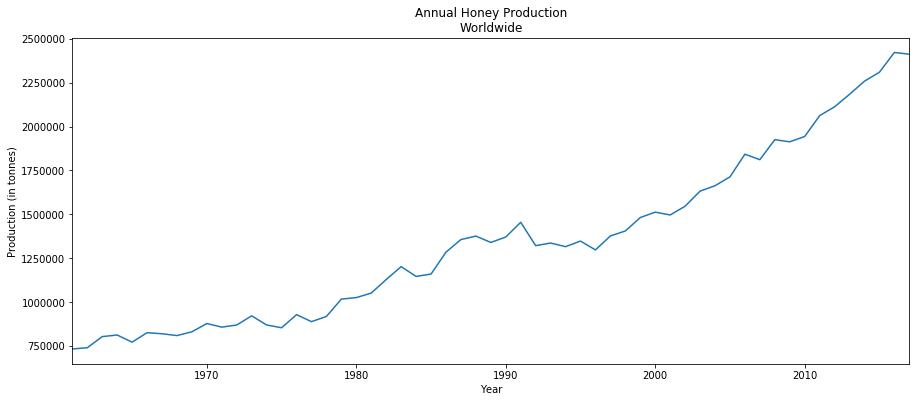

In [6]:
honey_year_production = honey_production.groupby("Year")["Production Value"].sum()
plot_time_serie(honey_year_production, 'Production (in tonnes)', 'Year', 'Annual Honey Production\nWorldwide')

We can observe that the honey production increased almost monotonically since the 60s.

Now let's see the Trade matrix.

In [7]:
def print_corrcoef(exports, imports, name):
    print(f"The correlation between imports and exports of {name} is {exports.corr(imports, method='pearson')}.")

The correlation between imports and exports of beehives (in unit) is -0.07476498880707769.
The correlation between imports and exports of beehives (in 1000 $US) is 0.8813326996733277.


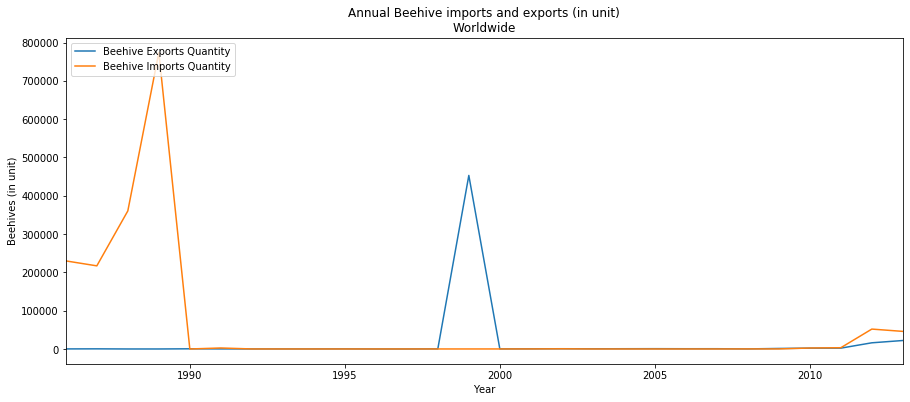

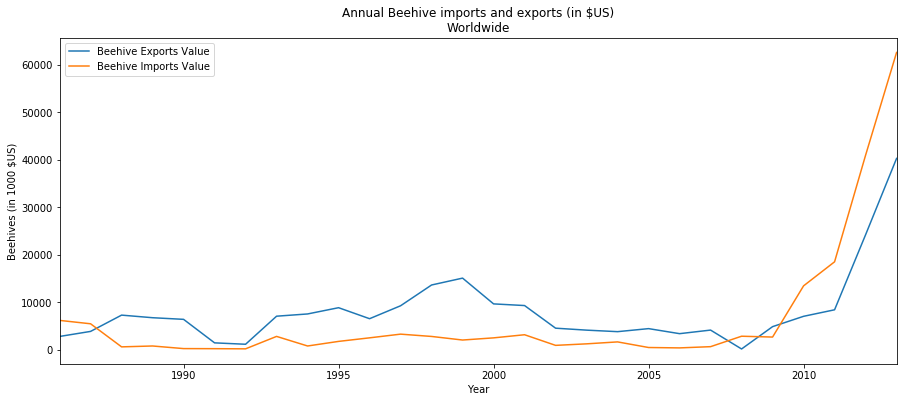

In [8]:
beehives = trade_matrix[(trade_matrix["Item"] == "Beehives")]

beehives_imports = beehives[(beehives["Element"] == "Import Quantity")]
imports = beehives_imports.groupby("Year").sum()["Value"]

beehives_exports = beehives[(beehives["Element"] == "Export Quantity")]
exports = beehives_exports.groupby("Year").sum()["Value"]

plot_time_series([exports, imports ], ['Beehive Exports Quantity', 'Beehive Imports Quantity'], "Beehives (in unit)", "Year", "Annual Beehive imports and exports (in unit)\nWorldwide")
print_corrcoef(exports, imports, "beehives (in unit)")
      
beehives_imports = beehives[(beehives["Element"] == "Import Value")]
imports = beehives_imports.groupby("Year").sum()["Value"]

beehives_exports = beehives[(beehives["Element"] == "Export Value")]
exports = beehives_exports.groupby("Year").sum()["Value"]

plot_time_series([exports, imports ], ['Beehive Exports Value', 'Beehive Imports Value'], "Beehives (in 1000 $US)", "Year", "Annual Beehive imports and exports (in $US)\nWorldwide")
print_corrcoef(exports, imports, "beehives (in 1000 $US)")

In [9]:
Albania_Macedonia_beehives_trades = beehives[(beehives["Reporter Countries"] == 'Albania') & (beehives["Partner Countries"] == 'North Macedonia') & (beehives["Value"] > 0) & (beehives["Year"] == 2009)]
print(f"We have {Albania_Macedonia_beehives_trades.shape[0]} link between Albania and North Macedonia.")
Albania_Macedonia_beehives_trades

We have 1 link between Albania and North Macedonia.


,Domain Code,Domain,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
289,TM,Detailed trade matrix,3,Albania,154,North Macedonia,5622,Import Value,1181,Beehives,2009,2009,1000 US$,2,NaN,Official data


We should expect the same value of imported and exported beehives per year, which is not the case here (see figures above). We would expect symmetrical behaviour (export from A to B <=> import from B to A), which is not the case in the example above. The correlation coefficient is not high enough to use them. Thus, `beehives` exports and imports can not be used here.

In [10]:
honey = trade_matrix[trade_matrix["Item"] == "Honey, natural"]

honey_imports = honey[honey["Element"] == "Import Quantity"]
honey_imports = honey_imports[["Reporter Countries", "Year", "Value"]]
honey_imports = honey_imports.rename(columns={"Reporter Countries": "Country", "Value": "Import Value"})

honey_exports = honey[honey["Element"] == "Export Quantity"]
honey_exports = honey_exports[["Reporter Countries", "Year", "Value", "Partner Countries"]]
honey_exports = honey_exports.rename(columns={"Reporter Countries": "Country", "Value": "Export Value"})

We will now see if the honey imports and exports are more usable.

The correlation between imports and exports of honey is 0.9900288530138095.


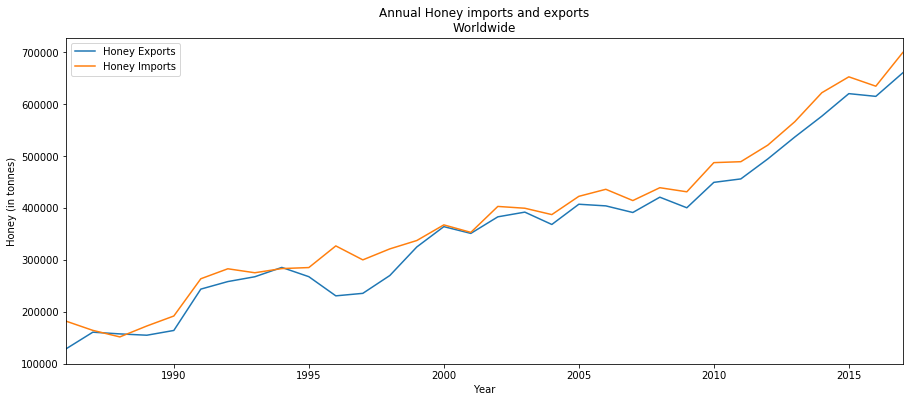

In [11]:
exports = honey_exports.groupby(["Year"]).sum()["Export Value"]
imports = honey_imports.groupby(["Year"]).sum()["Import Value"]

plot_time_series([exports, imports ], ['Honey Exports', 'Honey Imports'], "Honey (in tonnes)", "Year", "Annual Honey imports and exports\nWorldwide")
print_corrcoef(exports, imports, "honey")

We can see that the two curves are very similar. We will focus our analysis on the honey exports and imports since the data seems more usable.

In [12]:
exports_country = honey_exports.groupby(["Year", "Country"]).agg('sum')
imports_country = honey_imports.groupby(["Year", "Country"]).agg('sum')

In [13]:
exports_country.head()

Export Value
Year Country                         
1986 Argentina                  18601
     Australia                   9536
     Austria                       82
     Belgium-Luxembourg          1553
     Belize                       249

We will go deeper in the dataset and try to see how the honey is distributed between exports and imports over the world.

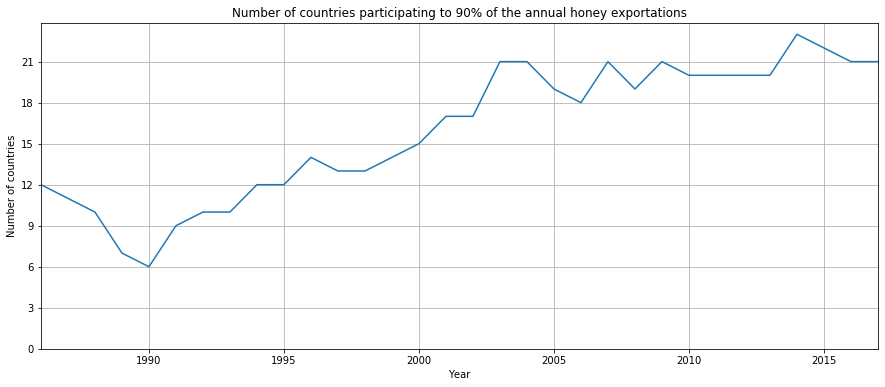

In [14]:
top_exporters = exports_country.copy()
top_exporters.reset_index(inplace=True) 
top_exporters['ratio'] = top_exporters["Export Value"] / top_exporters['Export Value'].groupby(top_exporters['Year']).transform('sum')
top_exporters = top_exporters.sort_values("ratio", ascending = False)
top_exporters["cumulative sum"] = top_exporters["ratio"].groupby(top_exporters['Year']).transform('cumsum')

top_exporters = top_exporters[top_exporters["cumulative sum"]<0.9]
best_exporters = top_exporters.groupby("Year")["Country"]
ax = plot_time_serie(best_exporters.count(), ylabel="Number of countries", xlabel="Year", title="Number of countries participating to 90% of the annual honey exportations")
ax.set_yticks(range(0,24,3))
plt.grid()

We can observe that the number of big honey exporters increased last years. This can show a good health of the honey market, let's see the import data to improve our analysis.

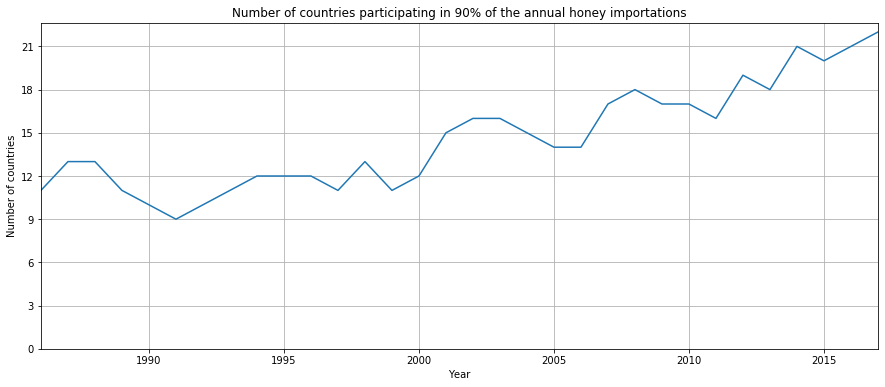

In [15]:
top_importers = imports_country.copy()
top_importers.reset_index(inplace=True) 
top_importers['ratio'] = top_importers["Import Value"] / top_importers['Import Value'].groupby(top_importers['Year']).transform('sum')
top_importers = top_importers.sort_values("ratio", ascending = False)
top_importers["cumulative sum"] = top_importers["ratio"].groupby(top_importers['Year']).transform('cumsum')

top_importers = top_importers[top_importers["cumulative sum"]<0.9]
best_importers = top_importers.groupby("Year")["Country"]
ax = plot_time_serie(best_importers.count(), ylabel="Number of countries", xlabel="Year", title="Number of countries participating in 90% of the annual honey importations")
ax.set_yticks(range(0,24,3))
plt.grid()

We can notice that the number of important importers increased. These countries may not produce enough honey for their consumption anymore. We will try to identify them in the following analysis.

We will try to observe honey exchanges trends for some countries. For that we pick import and export values of each country. We also compute a new value for our analysis called the **Honey Consumption**. It represents the quantity of honey which a country consumes per year and is computed as follows (for one year):

$$ \textrm{Honey Consumption} = \textrm{Honey Production} - \textrm{Honey Exports} + \textrm{Honey Imports} $$

In [144]:
exchanges = pd.merge(honey_production, exports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges = pd.merge(exchanges, imports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges["Honey Consumption"] = exchanges["Production Value"] - exchanges["Export Value"] + exchanges["Import Value"]
exchanges["Balance"] = exchanges["Export Value"] - exchanges["Import Value"]
exchanges = exchanges.set_index('Year')

# Changes beginning

In [137]:
def max1(x):
    return min(max(0,x) ,1)

In [145]:
exchanges["import_ratio"] = (exchanges["Import Value"] / exchanges["Honey Consumption"]).apply(max1)
exchanges["export_ratio"] = (exchanges["Export Value"] / exchanges["Honey Consumption"]).apply(max1)
exchanges = exchanges.reset_index()
exchanges = exchanges.fillna(0)
exchanges["Production Value"] = exchanges["Production Value"].astype(int)
exchanges = exchanges.sort_values("Year")

In [159]:
exchanges["Honey Consumption"] = exchanges["Production Value"].astype(int)

In [148]:
continents = json.loads(open('data/country-by-continent.json').read())

In [149]:
def find_continent(country):
    for c in continents:
        if c['country'] == country:
            return c['continent']
    print(country)

In [151]:
not_country = ["Belgium-Luxembourg", "Yugoslav SFR", "USSR", "Réunion", "Serbia and Montenegro", "Fiji"]

In [152]:
exchanges = exchanges[~exchanges['Country'].isin(not_country)]

In [153]:
exchanges["Continent"] = exchanges["Country"].apply(find_continent)

In [160]:
import plotly.express as px
px.scatter(exchanges, x="import_ratio", y="export_ratio", animation_frame="Year", animation_group="Country",
           size="Honey Consumption", color="Continent", hover_name="Country",
        size_max=55, range_x=[-0.1,1.1], range_y=[-0.1,1.1])

##### Conclusion

We can observe 3 different kind of countries:
- The countries which **export** the greater part of their honey production (Argentina)
- The countries which **import** the greater part of their honey (France, USA, Japan)
- The countries which **use** the greater part of their honey (China)

We observe that the world is split between honey producers and consumers. Western countries seem to have had production issues in the last decades while other countries became big exporters.